In [1]:
import os
import random
import numpy as np
import pandas as pd

import cv2
cv2.ocl.setUseOpenCL(False)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer, MinMaxScaler, LabelBinarizer

from mlxtend.plotting import plot_decision_regions
from matplotlib import pyplot as plt
from matplotlib import transforms

from tqdm import tqdm
import re

import tensorflow as tf

#Si vous n'avez pas de GPU ou que vous ne voulez pas l'utiliser, commentez les 2 lignes suivantes
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(tf.__version__)
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16

from tensorflow.keras.preprocessing import image    
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras
from tensorflow.keras.models import load_model

LE = LabelEncoder()

from PIL import Image

2.4.1


In [2]:
os.environ['TF_DETERMINISTIC_OPS'] = '1' #  c'est la ligne la plus importante
os.environ['PYTHONHASHSEED'] = '42'
os.environ['CUDA_VISIBLE_DEVICES'] = '' #  c'est facultatif
os.environ['OPENCV_OPENCL_DEVICE'] = 'disabled'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
encoder = LabelBinarizer()

def load_and_preprocess_image(path):
        image = cv2.imread(path)
        image = cv2.resize(image, (224,224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    
def split_data_by_env(env):
    BASEPATH = "../data/" + env +"/"

    LABELS = set()

    paths = []

    for d in os.listdir(BASEPATH):
        LABELS.add(d)
        paths.append((BASEPATH+d, d))

    X = []
    y = []

    for path, label in paths:
        for image_path in os.listdir(path):
            image = load_and_preprocess_image(path+"/"+image_path)

            X.append(image)
            y.append(label)

    X = np.array(X)
    y = encoder.fit_transform(np.array(y))
    
    return X, y, LABELS, paths



In [4]:
X_train, y_train, LABELS_train, paths_train = split_data_by_env("train")
X_test, y_test, LABELS_test, paths_test = split_data_by_env("test")

In [17]:
base_model=VGG16(weights='imagenet',include_top=False)

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(1024,activation='relu')(x)
x=Dropout(0.5)(x)
x=Dense(512,activation='relu')(x)
preds=Dense(len(LABELS_train),activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=preds)

for layer in model.layers[:-5]:
    layer.trainable=False
for layer in model.layers[-5:]:
    layer.trainable=True
    
model.compile("adam",loss="categorical_crossentropy",metrics=["accuracy"])

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [18]:
early_stopping = EarlyStopping(patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3,verbose=1)

In [19]:
history = model.fit(X_train,y_train,batch_size=64,epochs=50,validation_data=(X_test,y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/50
258/258 [==============================] - 33s 127ms/step - loss: 4.4909 - accuracy: 0.1157 - val_loss: 2.2076 - val_accuracy: 0.3914
Epoch 2/50
258/258 [==============================] - 32s 125ms/step - loss: 2.2295 - accuracy: 0.3843 - val_loss: 1.8964 - val_accuracy: 0.4629
Epoch 3/50
258/258 [==============================] - 32s 125ms/step - loss: 1.8330 - accuracy: 0.4768 - val_loss: 1.8159 - val_accuracy: 0.4734
Epoch 4/50
258/258 [==============================] - 33s 129ms/step - loss: 1.6430 - accuracy: 0.5155 - val_loss: 1.7392 - val_accuracy: 0.5072
Epoch 5/50
258/258 [==============================] - 34s 133ms/step - loss: 1.4286 - accuracy: 0.5764 - val_loss: 1.7823 - val_accuracy: 0.5091
Epoch 6/50
258/258 [==============================] - 32s 125ms/step - loss: 1.3020 - accuracy: 0.6072 - val_loss: 1.7339 - val_accuracy: 0.5186
Epoch 7/50
258/258 [==============================] - 32s 125ms/step - loss: 1.1270 - accuracy: 0.6570 - val_loss: 1.7132 - val_ac

## Accuracy plotting after training

In [26]:
model.save('../models/VGG16_MODEL.h5')

In [6]:
model = load_model('../models/VGG16_MODEL.h5')

Text(0.5, 1.0, 'Training and validation loss')

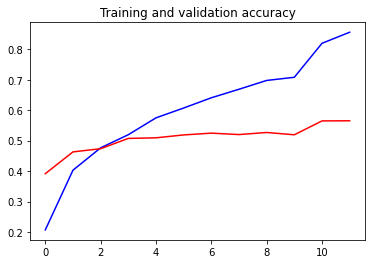

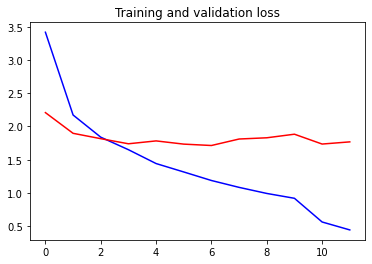

In [27]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, "b", label='accuracy')
plt.plot(epochs, val_acc, "r", label='validation_accuracy')
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, "b", label='loss')
plt.plot(epochs, val_loss, "r", label='validation_loss')
plt.title('Training and validation loss')

In [7]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print(f"loss on the test set is {loss:.2f}")
print(f"accuracy on the test set is {acc:.3f}")

loss on the test set is 1.71
accuracy on the test set is 0.524


In [8]:
predictions = model.predict(X_test)

In [9]:
label_predictions = encoder.inverse_transform(predictions)

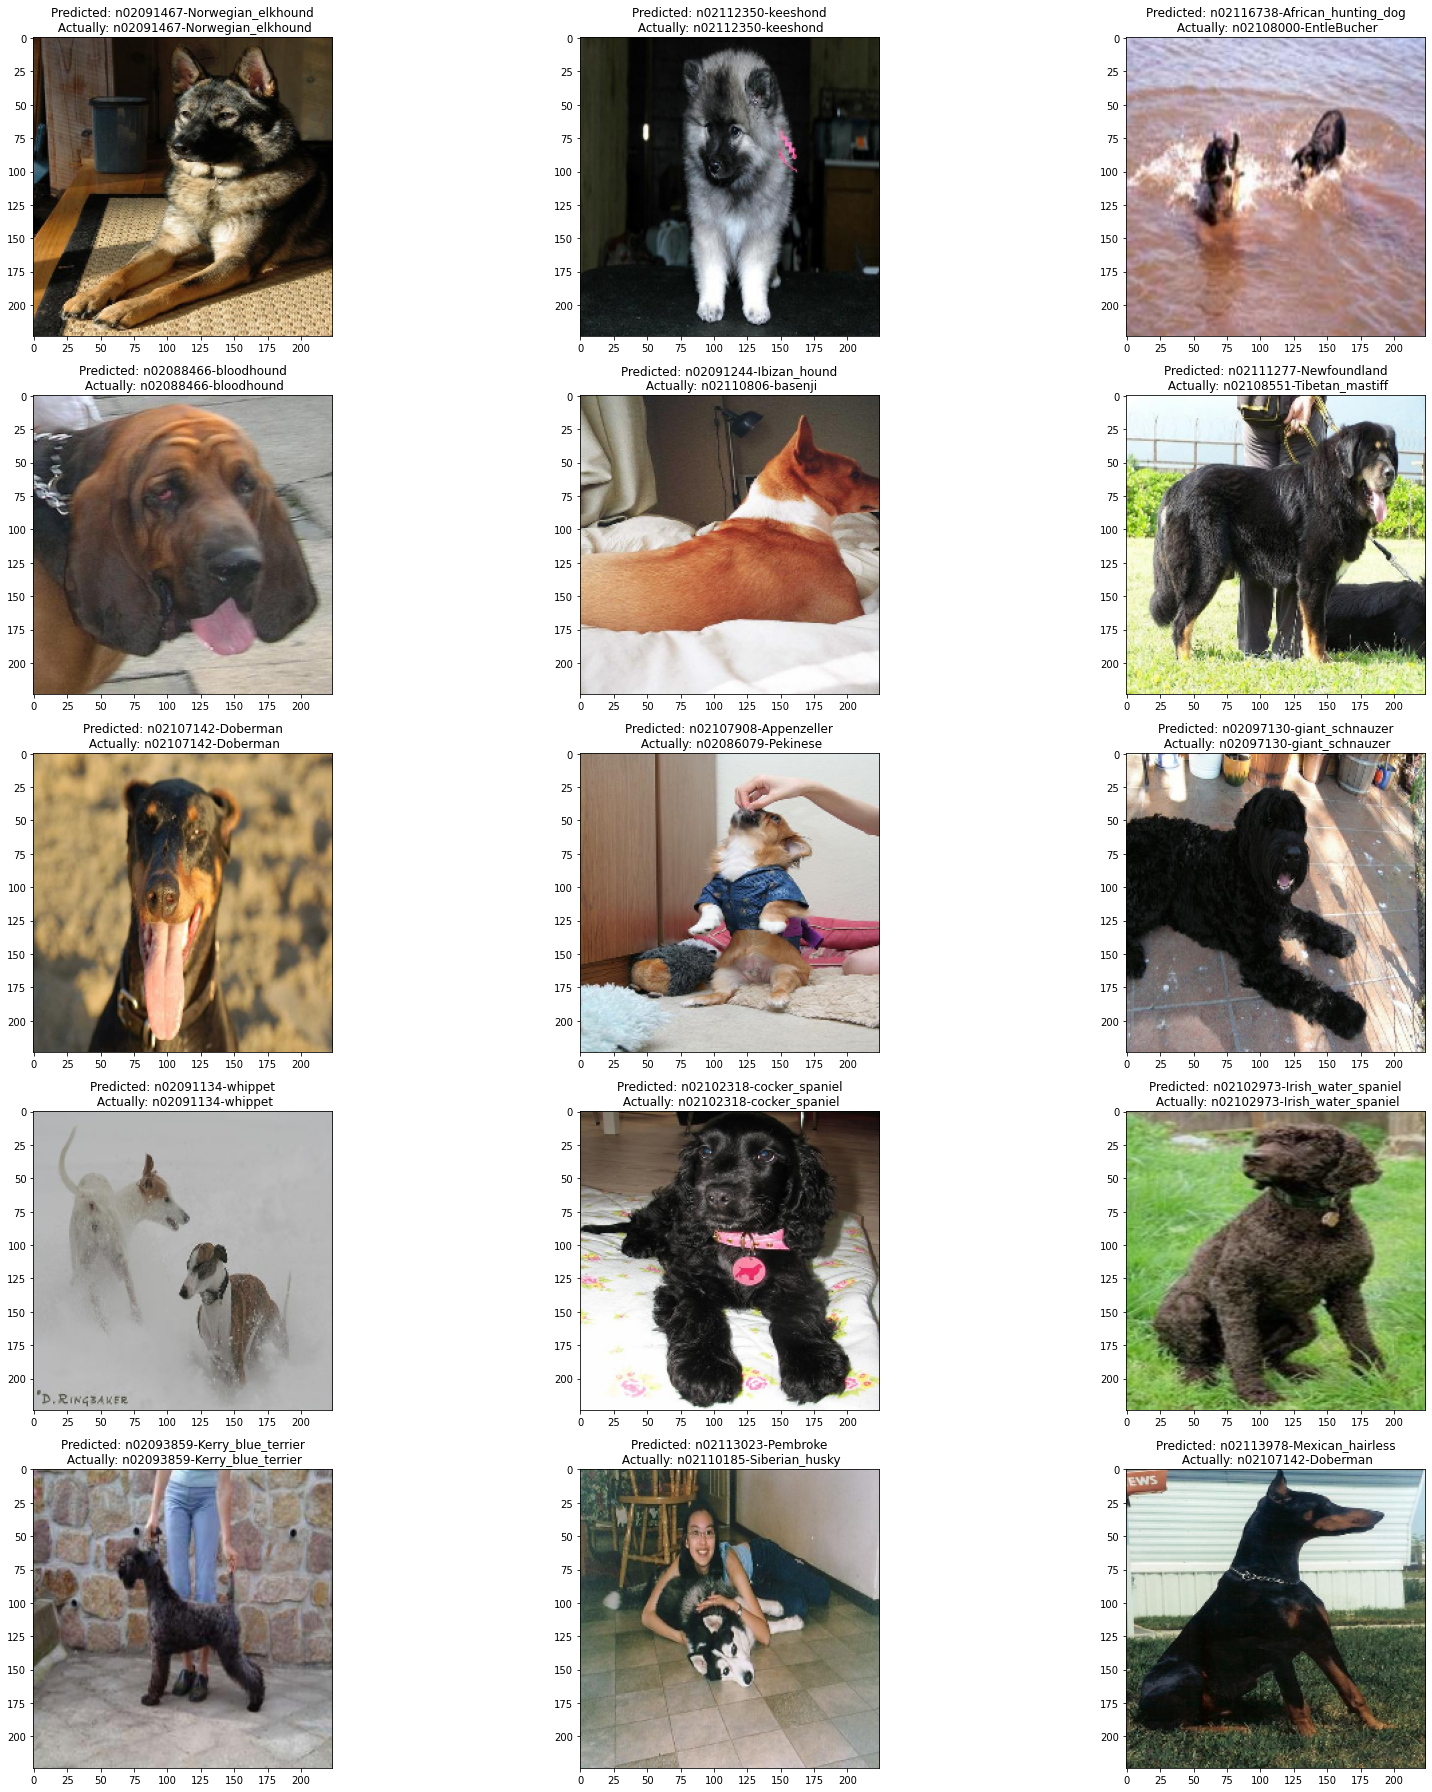

In [10]:
rows, cols = 5, 3
size = 25

fig,ax=plt.subplots(rows,cols)
fig.set_size_inches(size,size)
for i in range(rows):
    for j in range (cols):
        index = np.random.randint(0,len(X_test))
        ax[i,j].imshow(X_test[index])
        ax[i,j].set_title(f'Predicted: {label_predictions[index]}\n Actually: {encoder.inverse_transform(y_test)[index]}')
        
plt.tight_layout()